In [1]:
from PIL import Image
import os
import requests
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import os
import subprocess
import requests
import glob

In [2]:
np.random.seed(20)

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

In [4]:
def get_prediction(img_path, threshold):
    
    img = Image.open(img_path)

    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    pred = model([img])

    pred_data = pred[0]

    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    scores = pred_data['scores'].detach().cpu().numpy()

    valid_indices = scores > threshold

    pred_boxes = [((b[0], b[1]), (b[2], b[3])) for b in boxes[valid_indices]]
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]

    return pred_boxes, pred_class




def object_detection_api(
    img_path,
    threshold=0.5
):

    boxes, pred_cls = get_prediction(img_path, threshold)

    img = cv2.imread(img_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
    
    text_th = max(rect_th - 1, 1)

    for i in range(len(boxes)):
        
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]

        cv2.rectangle(
            img,
            p1,  
            p2,  
            color=color,  
            thickness=rect_th  
        )

        w, h = cv2.getTextSize(
            pred_cls[i],  
            0, 
            fontScale=rect_th / 3,  
            thickness=text_th  
        )[0]  

        outside = p1[1] - h >= 3  
        
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            img,
            p1,  
            p2,  
            color=color,  
            thickness=-1,  
            lineType=cv2.LINE_AA  
        )

        cv2.putText(
            img,
            pred_cls[i],  
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),  
            cv2.FONT_HERSHEY_SIMPLEX,  
            rect_th / 3,  
            (255, 255, 255),  
            thickness=text_th + 1 
        )

    plt.figure(figsize=(15,12))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def download_file(url, save_name):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_name, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print(f"File downloaded successfully: {save_name}")
    else:
        print(f"Failed to download file. Status Code: {response.status_code}")


In [6]:
inference_dir = "inference"  
os.makedirs(inference_dir, exist_ok=True)  


File downloaded successfully: inference\179260089.jpg


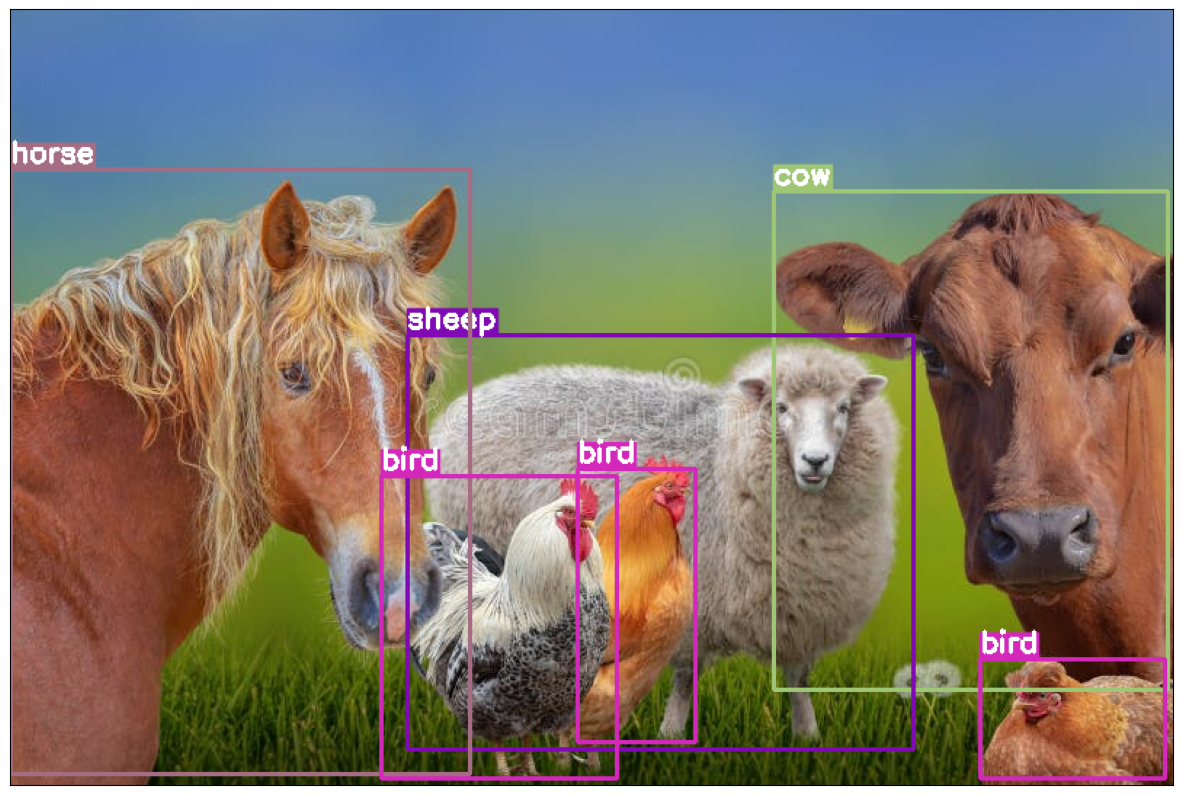

In [7]:
download_file(
    'https://thumbs.dreamstime.com/b/farm-animals-cow-sheep-chickens-hen-cock-horse-group-farmland-collage-179260089.jpg',
    os.path.join(inference_dir, '179260089.jpg')
)

image_path = os.path.join(inference_dir, '179260089.jpg')

if os.path.exists(image_path):
    object_detection_api(image_path, threshold=0.8)
else:
    print("Error: Image file not found. Object detection skipped.")


File downloaded successfully: inference\Africa.jpg


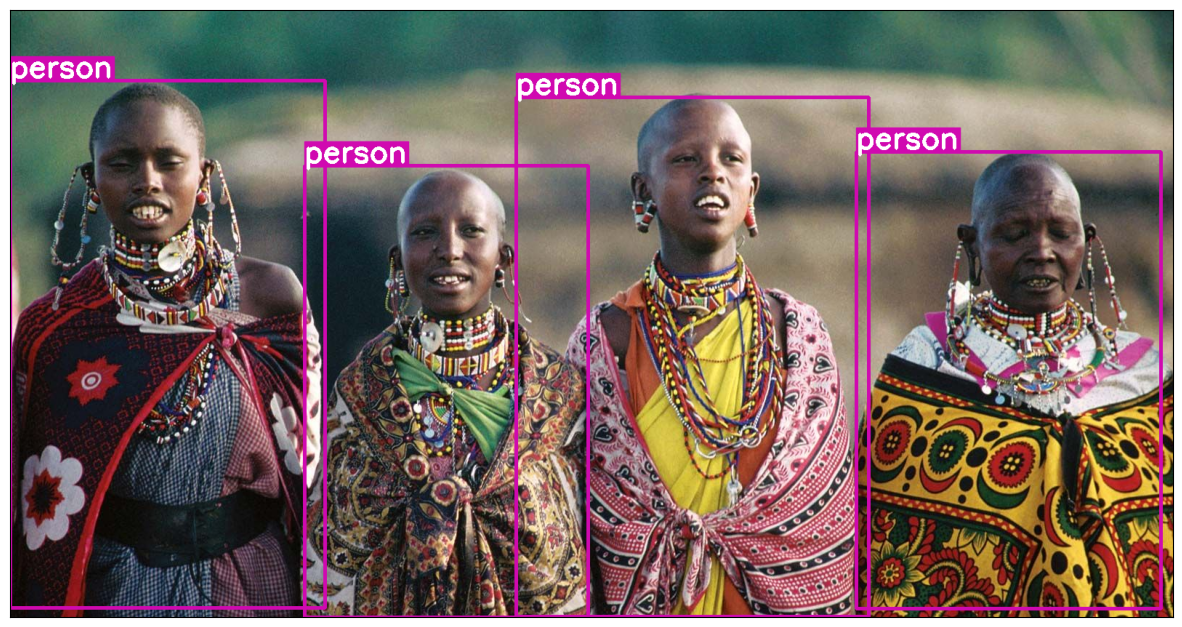

In [8]:
download_file(
    'https://cdn.britannica.com/60/160260-050-BAFE3093/Women-clothing-Kenya-East-Africa.jpg',
    os.path.join(inference_dir, 'Africa.jpg')
)

image_path = os.path.join(inference_dir, 'Africa.jpg')

if os.path.exists(image_path):
    object_detection_api(image_path, threshold=0.8)
else:
    print("Error: Image file not found. Object detection skipped.")
